<a href="https://colab.research.google.com/github/harsh-reactdev/ml-training/blob/main/id3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris




In [ ]:
# Load iris dataset
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["target"] = iris.target



In [ ]:
# Discretize continuous features (simple binning)
for col in iris.feature_names:
    df[col] = pd.qcut(df[col], q=3, duplicates="drop")



In [ ]:
# Entropy
def entropy(data):
    values, counts = np.unique(data, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))

# Information Gain
def information_gain(data, feature, target):
    total_entropy = entropy(data[target])
    values, counts = np.unique(data[feature], return_counts=True)

    weighted_entropy = 0
    for v, c in zip(values, counts):
        subset = data[data[feature] == v]
        weighted_entropy += (c / len(data)) * entropy(subset[target])

    return total_entropy - weighted_entropy



In [ ]:
# ID3 algorithm
def id3(data, features, target):
    # If all targets are same
    if len(np.unique(data[target])) == 1:
        return data[target].iloc[0]

    # If no features left
    if len(features) == 0:
        return data[target].mode()[0]

    # Select best feature
    gains = {f: information_gain(data, f, target) for f in features}
    best_feature = max(gains, key=gains.get)

    tree = {best_feature: {}}

    for value in np.unique(data[best_feature]):
        subset = data[data[best_feature] == value]
        if subset.empty:
            tree[best_feature][value] = data[target].mode()[0]
        else:
            remaining_features = [f for f in features if f != best_feature]
            tree[best_feature][value] = id3(subset, remaining_features, target)

    return tree

# Train ID3
features = iris.feature_names
tree = id3(df, features, "target")

print(tree)

{'petal width (cm)': {Interval(0.099, 0.867, closed='right'): np.int64(0), Interval(0.867, 1.6, closed='right'): {'petal length (cm)': {Interval(2.633, 4.9, closed='right'): np.int64(1), Interval(4.9, 6.9, closed='right'): {'sepal length (cm)': {Interval(5.4, 6.3, closed='right'): {'sepal width (cm)': {Interval(1.999, 2.9, closed='right'): np.int64(2)}}, Interval(6.3, 7.9, closed='right'): np.int64(2)}}}}, Interval(1.6, 2.5, closed='right'): {'sepal width (cm)': {Interval(1.999, 2.9, closed='right'): np.int64(2), Interval(2.9, 3.2, closed='right'): {'petal length (cm)': {Interval(2.633, 4.9, closed='right'): {'sepal length (cm)': {Interval(5.4, 6.3, closed='right'): np.int64(2)}}, Interval(4.9, 6.9, closed='right'): {'sepal length (cm)': {Interval(5.4, 6.3, closed='right'): np.int64(2), Interval(6.3, 7.9, closed='right'): np.int64(2)}}}}, Interval(3.2, 4.4, closed='right'): np.int64(2)}}}}


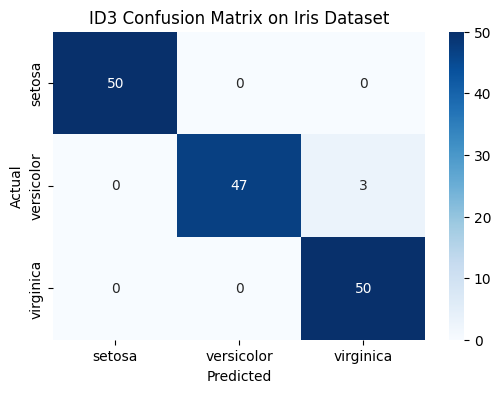

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict using ID3 tree
def predict(sample, tree):
    if not isinstance(tree, dict):
        return tree
    feature = list(tree.keys())[0]
    value = sample[feature]
    if value in tree[feature]:
        return predict(sample, tree[feature][value])
    else:
        return None

# Generate predictions
y_true = df["target"].values
y_pred = df.apply(lambda row: predict(row, tree), axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Seaborn visualization
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=iris.target_names,
    yticklabels=iris.target_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("ID3 Confusion Matrix on Iris Dataset")
plt.show()
